In [69]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import os
import astropy
from crashpy.utilities import crashMemMap
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
import illustris_python as il
from astropy.cosmology import FlatLambdaCDM

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [70]:
cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3089, Ob0=0.0486, Tcmb0=2.725)

### redshift_to_snap(redshift)
Simple function which converts a redshift into the corresponing snapshot name to easily construct the path to the halo

**Parameters**:
- **redshift**: Redshift you want to convert (has to be 6,8 or 10)

**Returns**:
- **snapname**: Name of the snapshot the **redshift** corresponds to

In [71]:
def redshift_to_snap(redshift):
    snapnames = {6:'sn013', 8:'sn008', 10:'sn004'}
    return snapnames[redshift]

In [72]:
def lum_str_to_float(string):
    string = string.replace('d', 'e')
    return float(string)

In [73]:
def source_dist_lum(ID, redshift, conf, side_length, r_v):
    snap = redshift_to_snap(redshift)
    path_sources = f'/ptmp/mpa/mglatzle/TNG_f_esc/{conf}/run/L35n2160TNG/{snap}/g{ID}/Input/sources_ic00.in'
    
    # 0.5 is needed to take into account that the sources are at the center of the grid voxel, move origin to halo center
    coord = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[0,1,2])+0.5-side_length/2
    lum = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[3])
    rel_dist = np.sqrt(np.sum(coord**2, axis=1))*2/side_length

    dist_lum_df = pd.DataFrame({'dist':rel_dist,'lum':lum[3]})
    
    return dist_lum_df

In [51]:
def r_fesc(df, mass_min, mass_max, conf, with_emitted=False):
    sub_df = df[(np.log10(df['StarMass'])>=mass_min) & (np.log10(df['StarMass'])<=mass_max)]
    age_all = []
    dist_all = []
    fesc_all = []
    n_ion_all = []
    for index, row in sub_df.iterrows():
        dist_lum_df = source_dist_lum(ID=row.ID, redshift=row.z, conf=conf, side_length=row.GridSize, r_v=row.HaloRadii)
        dist = dist_lum_df['dist']
        escaped = df['escaped_photons'][index].sum(axis=0)
        emitted = df['emitted_photons'][index].sum(axis=0) 
        fesc = df['per_source'][index]
        if with_emitted:
            n_ion=emitted
        else:
            n_ion = escaped
        age = df['StellarAges'][index]
        if len(age) != len(n_ion):
            print(index)
            print(len(age))
            print(len(n_ion))
        try:
            dist_all.extend(dist)
            fesc_all.extend(fesc)
            n_ion_all.extend(n_ion)
            age_all.extend(age)
        except:
            print(index)
            print(age)
    
    dist_all = np.array(dist_all)
    fesc_all = np.array(fesc_all)
    n_ion_all = np.array(n_ion_all)
    age_all = np.array(age_all)
    return (dist_all, fesc_all, n_ion_all, age_all)

### place_fesc(df)
Helper function that calculates the fraction of halos with an escape fraction below the threshold and sets these values to a small values above this threshold

**Parameters**:
- **fesc_arr**: Array of escape fractions
- **threshold**: Threshold below which the escape fraction is considered small (default: 1e-3)

**Returns**:
- **frac_small**: Fraction of halos with an escape fraction below **threshold**
- **fesc_arr**: Same as the input array with all values below **threshold** replaced by $f_\mathrm{esc} = 1.5 \cdot \mathrm{threshold}+\mathcal{U}(-0.5\cdot \mathrm{threshold},0.5\cdot \mathrm{threshold})$

In [7]:
def place_fesc(fesc_arr, threshold=1e-3):
    frac_small = (fesc_arr < threshold).sum()/len(fesc_arr)
    
    fesc_new = np.zeros_like(fesc_arr)
    for i, fesc in enumerate(fesc_arr):
        if fesc < threshold:
            fesc_new[i] = 1.5*threshold+np.random.uniform(-0.5*threshold, 0.5*threshold) 
        else:
            fesc_new[i] = fesc
    return frac_small, fesc_new

### get_scatter(df, halo_prop='StarMass', bins=30, mode='median', threshhold=1e-3)
Return means, error and variance of the escape fraction of each bin, the fraction of halos with small escape fraction for each bin as well as the centers of the bin for a dataframe

**Parameters**:
- **df**: Array of escape fractions
- **halo_prop**: Halo property along which to subdivide the dataframe can be either 'StarMass' or 'HaloMass' (default: 'StarMass')
- **bins**: Number of bins (default: 30)
- **mode**: How to calculate the average escape fraction 'mean' or 'median' (default: 'median')
- **threshold**: Threshold below which the escape fraction is considered small (default: 1e-3)



**Returns**:
- **x_values**: Masses (star or halo) of the individual halos
- **fesc**: f_esc of all halos
- **centers**: Centers of the logarithmically spaced bins
- **means**: Array of the average f_esc values
- **quantile16**: Values of the 16% quantile
- **quantile84**: Values of the 84% quantile
- **error**: Uncertainties in the average f_esc values
- **variance**: Variance in f_esc in a given bin
- **frac_small_arr**: Fraction of halos with f_esc below **threshold** in each bin 

In [8]:
def get_scatter(df_fesc, mode='r', bins=30, log=False, lim=1., average=False):
    
    if mode=='r':
        quant = 'dist'
    elif mode=='age':
        quant = 'age'
    elif mode=='n_ion':
        quant = 'dist'
        norm = df_fesc[df_fesc['dist']<lim]['n_ion'].sum()
    elif mode == 'a_r':
        quant = 'dist'
    elif mode == 'n_ion_a':
        quant = 'age'
        norm = df_fesc[df_fesc['dist']<lim]['n_ion'].sum()
    
    x_values = df_fesc[quant]
    if log:
        edges = np.logspace(np.log10(np.min(x_values)),np.log10(lim), bins)
        if mode == 'n_ion':
            raise NotImplementedError('The propper bin weighting for logarithmic density in the normalization is not implemented yet')
    else:
        edges = np.linspace(0,lim, bins)
    
    means = []
    quantile16 = []
    quantile84 = []
    centers = []
    
    lower_quant_boundary = 0.16
    upper_quant_boundary = 0.84
    
    for i in range(len(edges)-1):
        filt = (edges[i]*(1-1e-10)<df_fesc[quant]) & (df_fesc[quant]<edges[i+1])
        centers.append((edges[i]+edges[i+1])/2)
        
        if ((mode=='r') or (mode=='age')):
            sub_fesc = df_fesc[filt]['fesc']
            if average:
                means.append(sub_fesc.mean())
            else:
                means.append(sub_fesc.median())
            quantile16.append(sub_fesc.quantile(lower_quant_boundary))
            quantile84.append(sub_fesc.quantile(upper_quant_boundary))
        elif (mode=='a_r'):
            sub_ages = df_fesc[filt]['age']
            if average:
                means.append(sub_fesc.mean())
            else:
                means.append(sub_fesc.median())
            quantile16.append(sub_ages.quantile(lower_quant_boundary))
            quantile84.append(sub_ages.quantile(upper_quant_boundary))
        else:
            sub_n_ion = df_fesc[filt]['n_ion']
            sub_n_ion_sum = sub_n_ion.sum() 
            means.append(sub_n_ion_sum/norm)
            quantile16.append(None)
            quantile84.append(None)

    means = np.array(means)
    quantile16 = np.array(quantile16)
    quantile84 = np.array(quantile84)
    centers = np.array(centers)
        
    return centers, means, quantile16, quantile84

In [9]:
def star_ages(ID, redshift, conf, star_df):
    snap = redshift_to_snap(redshift)
    path_sources = f'/ptmp/mpa/mglatzle/TNG_f_esc/{conf}/run/L35n2160TNG/{snap}/g{ID}/Input/sources_ic00.in'
    
    star_ID_names = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[4])
    star_IDs = star_ID_names[4].apply(lambda element: int(element[1:-5]))

    a_formation = star_df.loc[star_IDs]['formation']
    z_formation = scale_to_red(a_formation)
    ages = (cosmo.age(redshift).value-cosmo.age(z_formation).value+0.005)*1000
    return ages

In [26]:
def plot_med_fesc_dep(df, mass_min_arr, mass_max_arr, mode='r', conf='fid2', labels=None, 
                      colors=['r','g','b'], bins=30, threshold=1e-3, average=True, save=False):
    
    labelsize = 50
    legendsize = 35
    ticksize = 35
    plt_linewidth  = 6
    ax_linewidth = 3
    fig_width = 20
    fig_height = 25
    y_lim_low = threshold
    legend_pos = 'lower right'
    x_tick_major_size = 20
    x_tick_major_width = 4
    x_tick_minor_size = 10
    x_tick_minor_width = 2

    if mode == 'r':
        x_label = r'$r/r_\mathrm{vir}$'
        y_label = r'$\langle f_\mathrm{esc} \rangle$'
    elif mode=='age':
        x_label = r'$a_\mathrm{star}$[Myr]'
        y_label = r'$\langle f_\mathrm{esc} \rangle$'
    elif mode == 'n_ion':
        x_label = r'$r/r_\mathrm{vir}$'
        y_label = r'$N_\mathrm{ion}/N_\mathrm{ion, tot}$'
    elif mode == 'a_r':
        x_label = r'$r/r_\mathrm{vir}$'
        y_label = r'$a_\mathrm{star}$[Myr]'
    elif mode == 'n_ion_a':
        x_label = r'$a_\mathrm{star}$[Myr]'
        y_label = r'$N_\mathrm{ion}/N_\mathrm{ion, tot}$'
    else:
        raise NotImplementedError(f'The mode {mode} is not implemented yet.')
    
    if len(mass_min_arr) != len(mass_max_arr):
        raise ValueError(f'Len of mass_min_arr has to be equal to len of mass_max_arr receiven {len(mass_min_arr)} and {len(mass_max_arr)} instead')
    if labels == None:
        labels = [i for i in range(len(mass_min_arr))]
    
    ax1 = plt.subplot2grid((4,1), (0,0), rowspan=2)
    max_values = np.zeros(len(mass_min_arr))
    for i in range(len(mass_min_arr)):
        centers, means = plot_fesc_dep(df, mass_min_arr[i], mass_max_arr[i], mode=mode, 
                                       conf=conf, bins=bins, return_result=True, average=average)
        max_values[i] = means.max()
        ax1.plot(centers, means, linewidth=plt_linewidth, label=labels[i], color=colors[i])
    if (mode=='n_ion') or (mode=='n_ion_a'):
        for i in range(len(mass_min_arr)):
            centers, means = plot_fesc_dep(df, mass_min_arr[i], mass_max_arr[i], mode=mode, 
                                           conf=conf, bins=bins, return_result=True, with_emitted=True)
            max_values[i] = means.max()
            ax1.plot(centers, means, linewidth=plt_linewidth, linestyle='dashed', color=colors[i])
    y_lim_high = 1.1*max_values.max()
    7
    if mode=='age':
        ax1.set_xscale('log')
        ax1.set_yscale('log')
    if mode=='n_ion_a':
        ax1.set_xscale('log')
        ax1.set_yscale('log')
    elif mode=='r':
        ax1.set_yscale('log')
    ax1.set_ylim(y_lim_low, y_lim_high)
    #ax1.set_xlim(x_lim_low, x_lim_high)
    
    ax1.set_ylabel(y_label, size=labelsize)
    ax1.set_xlabel(x_label, size=labelsize)
    ax1.tick_params(length=x_tick_major_size, width=x_tick_major_width)
    ax1.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')

    xticklabels = ax1.get_xticklabels()
    plt.legend(fontsize=legendsize, loc=legend_pos)
    plt.setp(xticklabels, visible=True)
    plt.rcParams["figure.figsize"] = (fig_width,fig_height)
    plt.rc('axes', linewidth=ax_linewidth)
    plt.rc('xtick', labelsize=ticksize) 
    plt.rc('ytick', labelsize=ticksize) 
    if save:
        path = f'/u/ivkos/analysis/plots/fesc_{mode}_variations.pdf'
        plt.savefig(path, bbox_inches = 'tight')
    plt.show()
    return

In [48]:
def plot_fesc_dep(df, mass_min, mass_max, mode='r', conf='fid2', bins=30, threshold=1e-3, 
                  save=False, return_result=False, with_emitted=False, average=True):        
    
    labelsize = 50
    legendsize = 40
    ticksize = 35
    plt_linewidth  = 6
    ax_linewidth = 3
    fig_width = 20
    fig_height = 25
    y_lim_low = threshold
    y_label = '$f_\mathrm{esc}$'
    legend_pos = 'lower right'
    x_tick_major_size = 20
    x_tick_major_width = 4
    x_tick_minor_size = 10
    x_tick_minor_width = 2
    
    dist, fesc, n_ion, age = r_fesc(df, mass_min, mass_max, conf=conf, with_emitted=with_emitted)
    print(len(dist))
    print(len(fesc))
    print(len(n_ion))
    print(len(age))
    fesc_df = pd.DataFrame({'dist':dist,'fesc':fesc, 'n_ion':n_ion, 'age':age})
    if mode=='r':
        x_label = r'$r/r_\mathrm{vir}$'
        x_quant=dist
        x_lim_low = 0.
        x_lim_high = 1.
        y_lim_high = fesc_df['fesc'].max()*1.1
        log=False
    elif mode=='n_ion':
        x_label = r'$r/r_\mathrm{vir}$'
        x_quant=dist
        x_lim_low = 0.
        x_lim_high = 1.
        y_lim_high = 0.15
        log=False
    elif mode=='age':
        x_label = r'$a_\mathrm{star}$[Myr]'
        x_lim_low = fesc_df['age'].min()
        x_lim_high = fesc_df['age'].max()
        y_lim_high = fesc_df['fesc'].max()*1.1
        x_quant=age
        log=True
    elif mode == 'a_r':
        x_label = r'$r/r_\mathrm{vir}$'
        x_quant=dist
        x_lim_low = 0.
        x_lim_high = 1.
        y_lim_high = 1.
        log=False
    elif mode == 'n_ion_a':
        x_label = r'$a_\mathrm{star}$[Myr]'
        x_quant=age
        x_lim_low = fesc_df['age'].min()
        x_lim_high = fesc_df['age'].max()
        y_lim_high = 0.15
        log=True
    else:
        raise NotImplementedError(f'The mode {mode} is not implemented yet.')
    
    centers, means, quantile16, quantile84 = get_scatter(fesc_df, mode=mode, bins=bins, log=log, lim=x_lim_high, average=average)
    
    if return_result:
        return (centers, means)
    _, fesc_plot = place_fesc(fesc, threshold)
    
    f = plt.figure()
    plt.subplots_adjust(hspace=0.001)

    ax1 = plt.subplot2grid((4,1), (0,0), rowspan=2)
    ax1.scatter(x_quant, fesc_plot)
    ax1.set_yscale('log')
    if mode=='age':
        ax1.set_xscale('log')
    ax1.set_ylim(y_lim_low, y_lim_high)
    ax1.set_xlim(x_lim_low, x_lim_high)
    ax1.plot(centers, means, linewidth=plt_linewidth,  color='red', label=r'$\langle f_\mathrm{esc} \rangle$')
    ax1.fill_between(centers, quantile16, quantile84, color='red', alpha=0.3)
    ax1.set_ylabel(y_label, size=labelsize)
    ax1.set_xlabel(x_label, size=labelsize)
    ax1.tick_params(length=x_tick_major_size, width=x_tick_major_width)
    ax1.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')

    xticklabels = ax1.get_xticklabels()
    plt.legend(fontsize=legendsize, loc=legend_pos)
    plt.setp(xticklabels, visible=True)
    plt.rcParams["figure.figsize"] = (fig_width,fig_height)
    plt.rc('axes', linewidth=ax_linewidth)
    plt.rc('xtick', labelsize=ticksize) 
    plt.rc('ytick', labelsize=ticksize) 
    if save:
        path = f'/u/ivkos/analysis/plots/fesc_r.pdf'
        plt.savefig(path, bbox_inches = 'tight')
    return

In [12]:
def add_age(df, conf, star_dic):
    ages = []
    for index, row in df.iterrows():
        age = star_ages(ID=row.ID, redshift=row.z, conf=conf, star_df=star_dic[row.z])
        ages.append(age)
    df['StellarAges'] = pd.Series(ages)
    return

In [13]:
def quick_update(df,h = 0.6774):
    df['StarMass']= df['HaloMass']*df['FractionStars']*1e10/h
    #add_age(df, sim_conf, star_dic)
    #df.to_pickle(new_df_name)
    return

In [14]:
def update_df(name, sim_conf, new_df_name, star_dic=None):
    df = pd.read_pickle(name)
    df['Q0/HaloMass']=df['Q0']/df['HaloMass']
    df['R_v^3/HaloMass']=df['HaloRadii']**3/df['HaloMass']
    df['StarMass']= df['HaloMass']*df['FractionStars']*1e10/h
    #add_age(df, sim_conf, star_dic)
    #df.to_pickle(new_df_name)
    return

In [15]:
def build_star_dic(basePath='/virgo/simulations/IllustrisTNG/L35n2160TNG/output'):
    stars_6 = il.snapshot.loadSubset(basePath, 13, 'stars', fields=['ParticleIDs', 'GFM_StellarFormationTime'])
    stars_8 = il.snapshot.loadSubset(basePath, 8, 'stars', fields=['ParticleIDs', 'GFM_StellarFormationTime'])
    stars_10 = il.snapshot.loadSubset(basePath, 4, 'stars', fields=['ParticleIDs', 'GFM_StellarFormationTime'])
    
    stars_6_df = pd.DataFrame({'formation':stars_6['GFM_StellarFormationTime']}, index=stars_6['ParticleIDs'])
    stars_8_df = pd.DataFrame({'formation':stars_8['GFM_StellarFormationTime']}, index=stars_8['ParticleIDs'])
    stars_10_df = pd.DataFrame({'formation':stars_10['GFM_StellarFormationTime']}, index=stars_10['ParticleIDs'])
    
    stars_6_df.sort_index(inplace=True)
    stars_8_df.sort_index(inplace=True)
    stars_10_df.sort_index(inplace=True)
    
    star_dic = {6:stars_6_df, 8:stars_8_df, 10:stars_10_df}
    return star_dic

In [16]:
def scale_to_red(a):
    return 1/a-1
def redshift_to_snap(redshift):
    snapnames = {6:'sn013', 8:'sn008', 10:'sn004'}
    return snapnames[redshift]
def redshift_to_snap_num(redshift):
    snapnumbers = {6:13, 8:8, 10:4}
    return snapnumbers[redshift]

In [17]:
def source_pos(ID, redshift, conf, side_length):
    snap = redshift_to_snap(redshift)
    path_sources = f'/ptmp/mpa/mglatzle/TNG_f_esc/{conf}/run/L35n2160TNG/{snap}/g{ID}/Input/sources_ic00.in'
    
    # 0.5 is needed to take into account that the sources are at the center of the grid voxel, move origin to halo center
    coord = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[0,1,2])
    lum = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[3])
    
    coord = np.array(coord)
    lum = np.vectorize(lum_str_to_float)(lum)
    
    halo_cube = np.zeros((side_length,  side_length, side_length))
    for i in range(coord.shape[0]):
        pos = coord[i,:]
        halo_cube[pos[0],pos[1],pos[2]]+=lum[i][0]*1e52
    return halo_cube

In [67]:
df=pd.read_pickle('dfs/full_esc_updated.pickle')
#quick_update(df)

In [19]:
conf='fid2'
redshift = 10
ID=4276
snap=redshift_to_snap(redshift)
snap_num=redshift_to_snap_num(redshift)

In [20]:
mass_min_arr2 = [6.0, 7.0, 8.0]
mass_max_arr2 = [6.5, 7.5, 8.5]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
labels = [r'$\log(M_\mathrm{Star})=6.0-6.5$',r'$\log(M_\mathrm{Star})=7.0-7.5$',r'$\log(M_\mathrm{Star})=8.0-8.5$']

In [21]:
modes = ['r', 'n_ion', 'age', 'a_r', 'n_ion_a']

In [61]:
df

,ID,z,HaloMass,Metallicity,GasMetallicity,FractionStars,FractionGas,FractionDust,Q0,HaloRadii,...,per_source,emitted_photons,escaped_photons,frequencies,n_iterations,clump_gas,sigma_gas_gal,sigma_star_gal,StellarAges,StarMass
0,18024,6,0.234591,0.001257,0.000484,0.001222,0.059822,0.000011,7.688735e+50,30.920389,...,"[3.253951591101243e-09, 1.222085112812222e-09,...","[[2.8176467195911484e-05, 0.000629387400416752...","[[0.0, 0.0, 0.0, 0.0, 1.4860568285293562e-144,...","[3288593900000000.0, 3290420400000000.5, 32939...",2,3.115873,1.032573,29220.919462,"[474.4272252947085, 88.00142782831122, 582.086...",4.231521e+06
1,5025,6,0.598136,0.001819,0.000587,0.001961,0.084026,0.000021,3.544364e+52,41.268627,...,"[3.802910823588919e-17, 1.0359338150912095e-12...","[[0.001984903320295341, 0.0003377246915029436,...","[[0.0, 0.0, 5.159449864060319e-85, 5.908668203...","[3288593900000000.0, 3290420400000000.5, 32939...",2,2.684760,1.918696,61361.636757,"[43.94104979918145, 98.86004069956522, 74.3267...",1.731587e+07
2,36099,6,0.110898,0.000693,0.000590,0.002472,0.088736,0.000023,5.984002e+50,21.909262,...,"[5.07941226321732e-05, 5.319216732752793e-06, ...","[[7.722153723588219e-06, 2.3649727136141585e-0...","[[6.427754495204763e-44, 1.5684717097756974e-1...","[3288593900000000.0, 3290420400000000.5, 32939...",2,2.253344,0.331720,16674.216288,"[599.3246382212224, 516.0250994982695, 551.150...",4.046436e+06
3,3205,6,0.850860,0.001759,0.000815,0.002625,0.099746,0.000028,5.915512e+52,48.385815,...,"[3.919890743533597e-21, 1.0269983720834602e-14...","[[0.00019560967101489595, 0.001829586567321662...","[[0.0, 5.164312530611517e-112, 4.0719515166821...","[3288593900000000.0, 3290420400000000.5, 32939...",2,6.204068,3.456773,40045.378454,"[115.43615507229433, 48.289865606659816, 240.8...",3.297333e+07
4,5444,6,0.549189,0.000635,0.000246,0.000807,0.069031,0.000008,3.360591e+52,34.273499,...,"[0.015181660328691383, 0.0019323418885207478, ...","[[3.3239760490464085e-05, 2.4212147039661305e-...","[[2.578722865957187e-08, 8.456658992889706e-15...","[3288593900000000.0, 3290420400000000.5, 32939...",2,2.312886,1.018395,17964.229138,"[442.53772040590337, 532.1743640080741, 601.12...",6.544893e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9545,23,10,1.990463,0.001560,0.000975,0.003036,0.908565,0.000294,4.676643e+53,63.787907,...,"[3.3248731316559215e-43, 3.136045302285354e-42...","[[0.2833044585573524, 0.0007232761145838291, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[3288593900000000.0, 3290420400000000.5, 32939...",2,6.142610,27.628287,28275.190615,"[246.54644329369518, 183.1787299735334, 95.733...",8.921042e+07
9546,1057,10,0.283640,0.000687,0.000503,0.001210,0.012709,0.000004,1.006748e+52,29.043325,...,"[0.05353043913705307, 0.05756470377774007, 0.0...","[[2.8145709720366567, 0.0065289720606798735, 0...","[[0.0489779339489124, 9.708270714453571e-05, 2...","[3288593900000000.0, 3290420400000000.5, 32939...",3,1.891447,1.502703,34190.353756,"[19.688976009384458, 36.49109309780912, 4.7798...",5.066942e+06
9547,1158,10,0.268558,0.000824,0.000361,0.000972,0.075143,0.000010,3.424150e+52,31.996222,...,"[4.968147275974992e-11, 5.224764045616403e-06,...","[[0.00012410301792982112, 0.000200602334093519...","[[0.0, 1.8178903908753442e-24, 5.4420177344312...","[3288593900000000.0, 3290420400000000.5, 32939...",2,2.021630,3.735654,25464.817792,"[93.68797740966306, 169.76874027281713, 211.13...",3.851999e+06
9548,2459,10,0.181152,0.000615,0.000845,0.001462,0.050235,0.000015,2.234372e+52,29.449396,...,"[2.3019012860291108e-07, 0.01561091063178752, ...","[[3.2294471346738095e-05, 0.000219707152361482...","[[6.84906359606858e-48, 1.1327661825938325e-07...","[3288593900000000.0, 3290420400000000.5, 32939...",2,2.097049,2.556313,24006.161800,"[15.595189645329295, 24.150259541590277, 238.1...",3.909148e+06


In [81]:
import pickle

In [82]:
path_to_data = '/u/ivkos/analysis/dfs/data'
name_star_mass_dic = 'star_masses.pickle'
path_star_masses = os.path.join(path_to_data, name_star_mass_dic)
with open(path_star_masses, 'rb') as handle:
    star_masses = pickle.load(handle)

In [78]:
def star_ages(ID, redshift, conf, star_df):
    snap = redshift_to_snap(redshift)
    path_sources = f'/ptmp/mpa/mglatzle/TNG_f_esc/{conf}/run/L35n2160TNG/{snap}/g{ID}/Input/sources_ic00.in'

    star_ID_names = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[4])
    star_IDs = star_ID_names[4].apply(lambda element: int(element[1:-5]))

    a_formation = star_df.loc[star_IDs]['formation']
    z_formation = scale_to_red(a_formation)
    ages = (cosmo.age(redshift).value-cosmo.age(z_formation).value+0.005)*1000
    return ages

In [86]:
def add_age(df, star_dic, index, conf='full_esc'):
    row = df.loc[index]
    age = star_ages(ID=row.ID, redshift=row.z, conf=conf, star_df=star_dic[row.z])
    print(len(age))
    print(age)
    return

In [89]:
add_age(df, star_masses, 6714)

35
[  7.99376389 255.80911063 118.67672326 289.49920779 294.51235852
 366.73036658 223.43805294 255.11748446 280.55294074  18.64715624
 274.02507674 231.59158183 259.9329665  276.65016566 266.03688658
  47.43341306  72.36162731 285.05395249  69.81424716 182.66181974
 171.02480354 210.51943984 267.3800565   14.18342632 253.7306611
  42.10513206  33.48091385  76.41413126  18.09099194 356.67694947
 169.33861292 212.82765897 273.36581389  63.65405813  21.97433479]


In [88]:
df.loc[6680].StellarAges

array([ 73.88474445, 225.67755616, 246.01403564, 103.50983655,
       180.19249646, 137.94065129, 126.10017171, 139.73808325,
       153.45424753, 125.17797721, 162.10517947, 135.23237299,
       198.7922386 , 191.60438541, 199.97904009, 102.06575502,
       120.54245322,  76.9187188 , 243.88321701, 340.91015988,
       303.7219086 ,  13.06239239, 107.34207976, 349.42371906,
        29.39595665, 292.64074934, 108.29582935, 287.60087468,
        75.90921425, 401.40015944,  17.25559502,  36.72933959,
       165.52275782, 176.87948975, 203.52063699,  45.83982342,
       116.80433245,  36.1891084 ,   9.12357489, 457.95685258,
       298.84068831, 178.53891736,  95.27564386, 308.53419135,
       230.85690232,  98.1959671 , 274.02507674, 120.54245322,
       323.13891732,  51.13518492, 264.68888586,  88.89447328,
        37.80824681,  41.03375609,  81.68957629, 163.38959487,
        15.58169775,  38.88536165, 195.21268338, 417.68122012,
        91.84869273,  25.28382669, 380.21764766,  68.28

In [77]:
row.

8

In [74]:
#df.loc[6678]
df.loc[6680]['StellarAges'].shape
df.loc[6680]['per_source'].shape
df.loc[6680]['ID']
df.loc[6680]['z']

(392,)

(9,)

24620

8

6678
66
14
6680
392
9
6695
797
27
6697
1922
18
6702
1805
22
6711
33
12
6712
35
33
6714
102
35
6726
9
21
6728
14
9
6729
19
28
6730
215
14
6731
33
19
6737
92
21
6738
6
37
6740
61
6
6741
351
6
6746
131
16
6747
149
12
6752
33
12
6754
1601
33
6755
46
28
6759
140
17
6768
602
21
6771
9
26
6773
332
9
6778
62
5
6783
15
9
6785
18
15
6786
40
6
6787
77
18
6791
51
26
6798
619
34
6799
348
17
6804
243
18
6805
75
15
6810
453
23
6816
75
24
6817
99
25
6823
35
16
6829
26
6
6834
40
21
6835
45
27
6836
48
40
6839
144
22
6843
65
7
6844
156
25
6849
42
31
6852
108
36
6859
15
40
6861
141
15
6865
18
9
6866
37
13
6867
31
18
6868
137
37
6872
27
31
6874
11
27
6876
57
11
6877
97
11
6880
17
18
6882
22
17
6884
33
22
6886
176
33
6892
17
26
6894
463
17
6895
58
30
6898
89
23
6901
384
17
6906
25
31
6908
90
25
6912
14
16
6914
40
14
6917
168
31
6918
553
5
6921
35
23
6929
20
21
6931
65
20
6932
17
33
6934
9
17
6936
16
9
6937
36
19
6938
283
16
6939
58
36
6946
355
20
6947
1543
33
6952
12
27
6954
56
12
6960
153
24
6961
179
8
696

8543
65
22
8544
22
29
8545
72
25
8550
31
22
8551
34
19
8555
208
15
8556
33
18
8559
11
33
8560
17
35
8562
31
11
8563
21
17
8564
28
19
8565
34
31
8566
34
21
8567
49
28
8568
24
34
8569
38
34
8571
13
24
8574
109
13
8580
106
7
8582
41
15
8587
89
11
8588
65
16
8592
66
21
8596
64
31
8598
22
15
8600
19
15
8601
140
22
8603
202
19
8605
14
16
8607
6
13
8608
97
14
8609
14
27
8610
906
6
8612
172
14
8616
20
36
8617
34
32
8619
131
20
8625
86
9
8627
14
18
8630
68
14
8636
163
16
8637
13
16
8638
13
19
8640
28
13
8641
42
13
8645
73
9
8652
81
12
8659
14
5
8662
8
14
8663
38
21
8664
52
31
8665
5
8
8668
23
5
8673
16
3
8676
59
16
8680
20
23
8683
17
20
8685
41
9
8687
213
13
8691
45
15
8692
44
13
8693
167
19
8697
54
33
8702
35
21
8703
15
19
8704
54
11
8706
57
15
8708
15
13
8711
53
15
8713
48
28
8715
21
14
8718
100
21
8720
26
29
8723
87
26
8724
28
18
8727
6
28
8730
23
6
8733
133
23
8734
18
12
8737
14
18
8739
33
9
8740
17
14
8743
161
17
8744
10
14
8747
44
10
8748
68
15
8752
65
16
8754
13
17
8756
43
13
8758
6
13
8

ValueError: arrays must all be same length

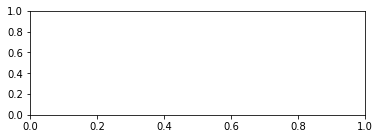

In [52]:
plot_med_fesc_dep(df, mass_min_arr2, mass_max_arr2, mode='r', conf='full_esc', labels=labels, bins=30, threshold=1e-3, average=True, save=True)

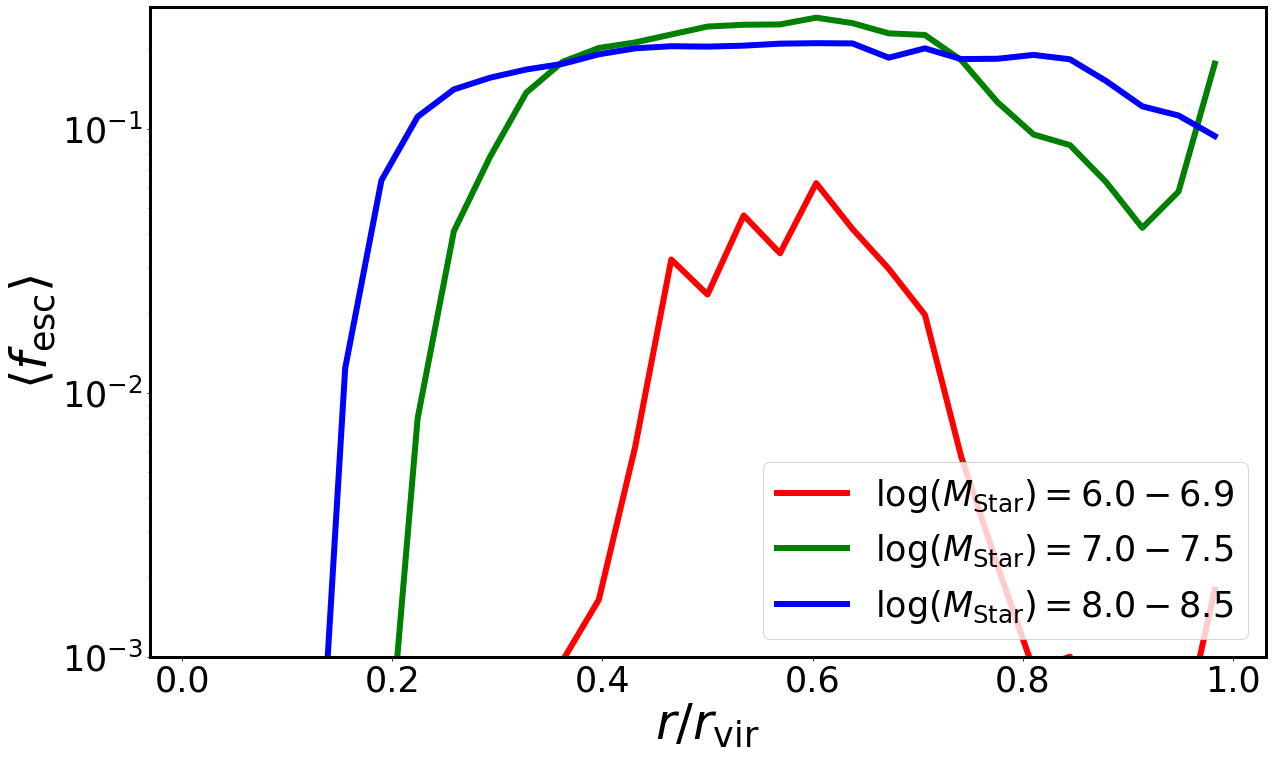

In [51]:
plot_med_fesc_dep(df, mass_min_arr2, mass_max_arr2, mode='r', conf='fid2', labels=labels, bins=30, threshold=1e-3, save=True)

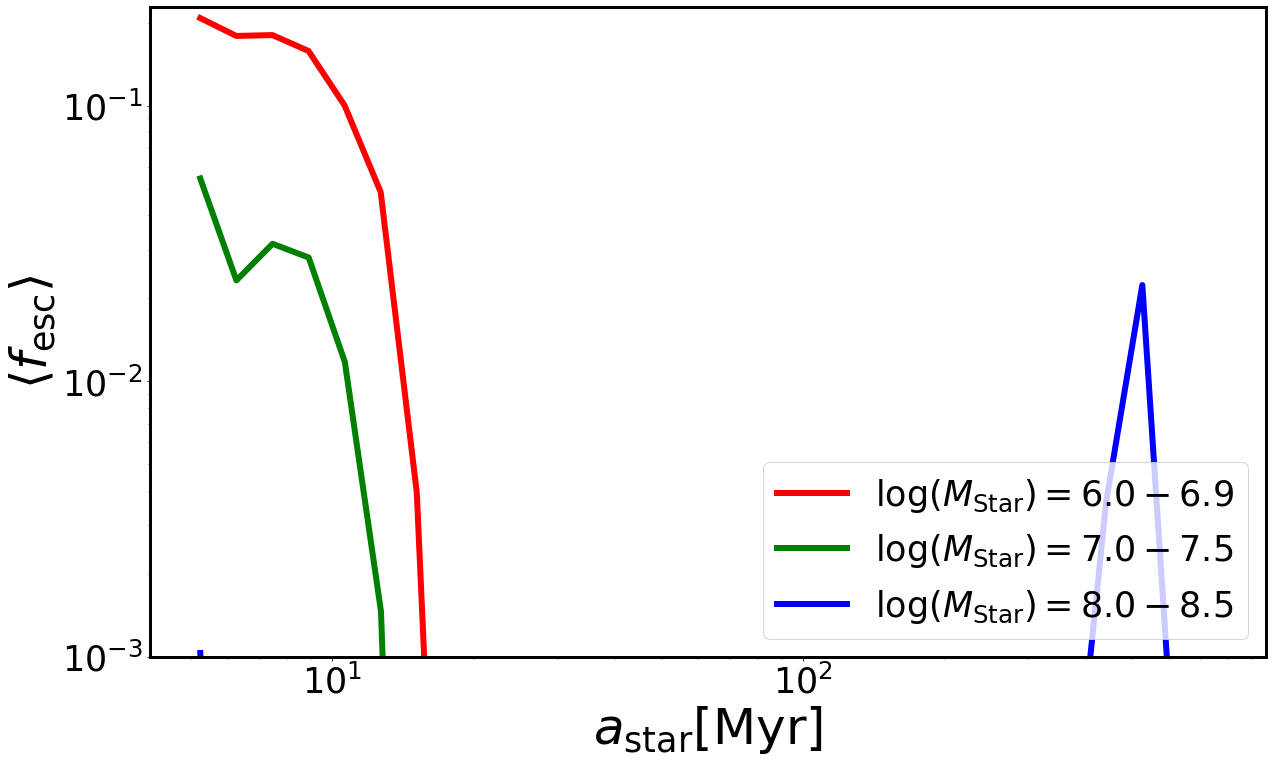

In [52]:
plot_med_fesc_dep(df, mass_min_arr2, mass_max_arr2, mode='age', conf='fid2', labels=labels, bins=30, threshold=1e-3, save=True)

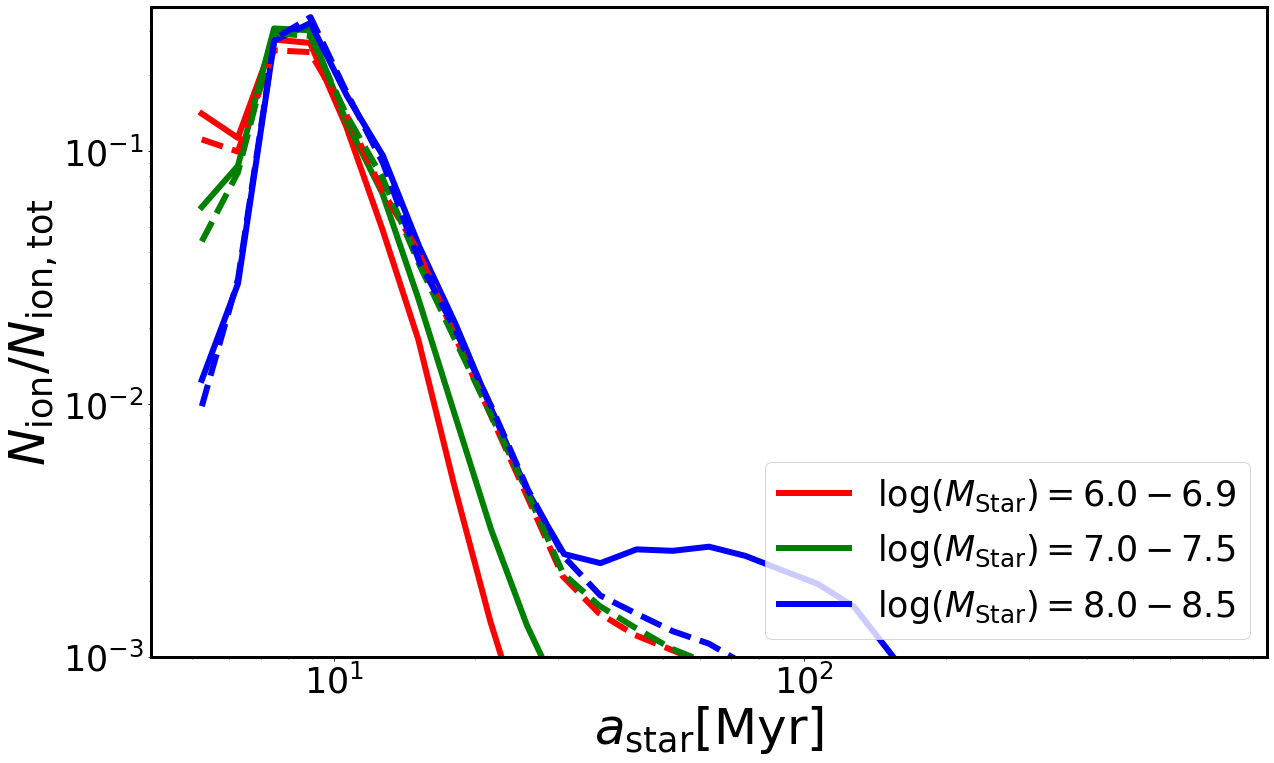

In [55]:
plot_med_fesc_dep(df, mass_min_arr2, mass_max_arr2, mode='n_ion_a', conf='fid2', 
                  labels=labels, bins=30, threshold=1e-3, save=True)

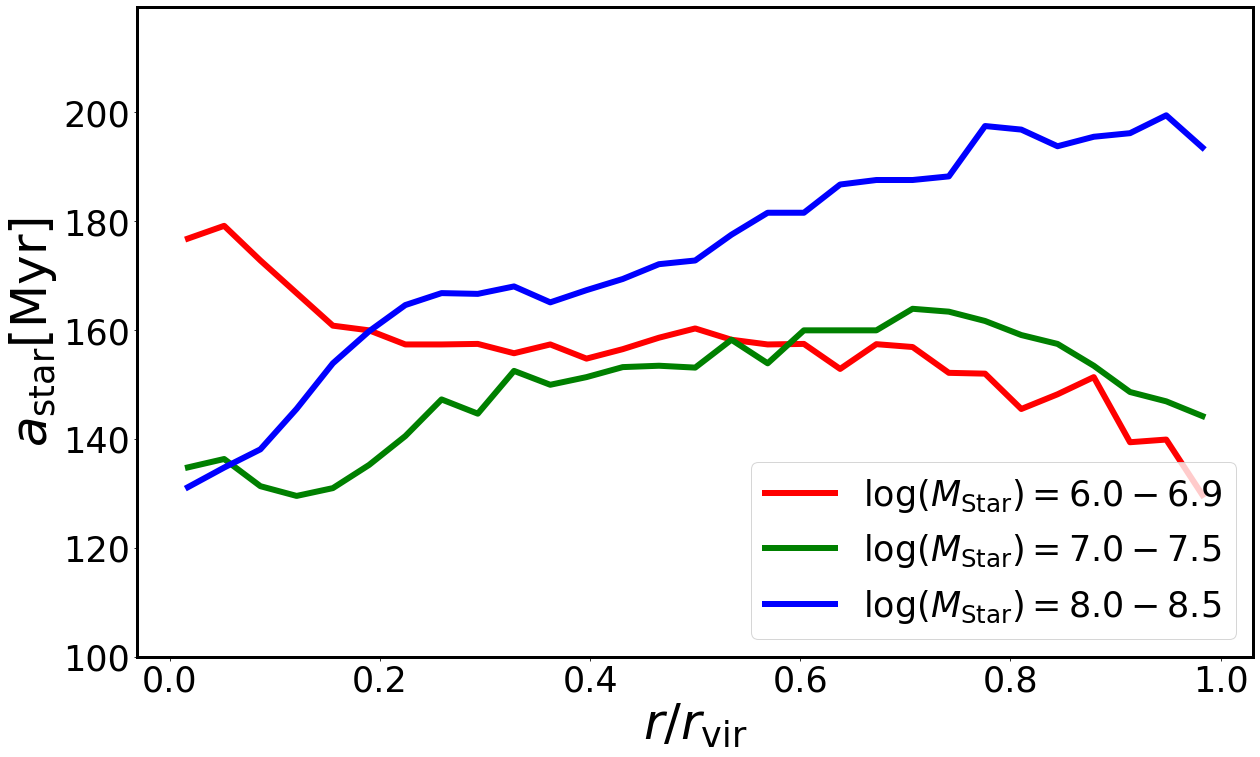

In [56]:
plot_med_fesc_dep(df, mass_min_arr2, mass_max_arr2, mode='a_r', conf='fid2', labels=labels, bins=30, threshold=100, save=True)